In [1]:
import pandas    as pd
import numpy     as np

In [3]:
df_train = pd.read_csv('Output_xgboost_binning/Training_set_xg_boost_binning.csv')
df_test  = pd.read_csv('Output_xgboost_binning/Testing_set_xg_boost_binning.csv')

# Functions

In [2]:
# %load load_list_var.py
def load_vars(type):

    if type == "numerical":

        vars = []
        with open("Data/num_var.txt", "r") as f:
            for line in f:
                vars.append(str(line.strip()))

    elif type == "categorical":

        vars = []
        with open("Data/cat_var.txt", "r") as f:
            for line in f:
                vars.append(str(line.strip()))

    else:

        print("Not properly loaded var, type is {}".format(type))

    return vars


In [5]:
def uniques_to_woe(variable,  target, col): # uniques_to_woe(variable, variable_test, target, target_test, col):
    '''
    picks a categorical variable and return the woe associated to each bin

    Parameters
    ----------
    variable :: array
        training predicting variable
        
    target :: array
        predicted variable

    col :: String
        Name of the variable
        
    Returns
    -------
    xy[col].values :: list
        each element is the woe corresponding to each row
    
    dropouts :: list
        variables that have no index associated
    '''
    
    
    xy         = pd.DataFrame((target,variable)).transpose()
    
    categories = list(variable.value_counts().index)
    
    dropouts   = []
    
    nans         = xy[pd.isnull(xy[col])]
    sum_positive = np.sum(nans['TARGET'])
    sum_negative = nans.shape[0] - sum_positive
    
    if sum_negative != 0:
        woe          = np.log(sum_positive/sum_negative)
    else:
        woe          = np.nan
    
    if not np.isfinite(woe):
        woe = np.nan 
        dropouts.append('nan')
        
    xy.loc[nans.index, col] =  woe
    
    woe_nan = woe
    
    for cat in categories:
        
        aux_df       = xy[xy[col] == cat]
        
        sum_positive = np.sum(aux_df['TARGET'])
        sum_negative = aux_df.shape[0] - sum_positive
        
        if sum_negative != 0:
            woe          = np.log(sum_positive/sum_negative)
        else:
            woe          = np.nan
        
        if not np.isfinite(woe):
            woe = woe_nan
            dropouts.append(cat)
            
        
        xy[col] = xy[col].replace([cat],woe)
        
    
     
    return xy[col].values,  dropouts

In [6]:
def categorical_to_numerical(dataframe, cat_vars): 
    
    
    relation_categorical_woe = {}
    
    
    for categorical in cat_vars: 
        print(categorical)
        
        woed_train, dropouts = uniques_to_woe(dataframe[categorical], dataframe['TARGET'], categorical)
        
        dataframe.loc[pd.isnull(dataframe[categorical]),categorical]     = 'nan'
        dataframe.loc[dataframe[categorical].isin(dropouts),categorical] = 'nan'

        
        cat_dic = dataframe[categorical].value_counts().index # save different clases with its name
                
        
        dataframe[categorical] = woed_train
        
        
        val_dic = dataframe[categorical].value_counts().index # save different classes with its woe associated
        

        relation_categorical_woe[categorical] = dict(zip(cat_dic, val_dic))
            
    return relation_categorical_woe

In [7]:
def df_test_to_categorical(df_test, relation_categorical_woe, cat_vars):
    
    for column in cat_vars:
        
        relations  = relation_categorical_woe[column]
        categories = list(relations.keys())
        
        df_test.loc[pd.isnull(df_test[column]),column]        = 'nan'
        df_test.loc[~df_test[column].isin(categories),column] = 'nan'
        
        for cat in categories:
            
            rows = df_test[column]  == cat
            
            df_test.loc[rows, column] = relations[cat]

# Running code

In [8]:
relation_categorical_num_woe = categorical_to_numerical(df_train, load_vars("numerical"))

CNT_CHILDREN
AMT_INCOME_TOTAL


<ipython-input-5-b28fbad60ae7>:57: RuntimeWarning: divide by zero encountered in log
  woe          = np.log(sum_positive/sum_negative)


AMT_CREDIT_x
AMT_ANNUITY_x


<ipython-input-5-b28fbad60ae7>:37: RuntimeWarning: divide by zero encountered in log
  woe          = np.log(sum_positive/sum_negative)


AMT_GOODS_PRICE_x
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START_x
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MO

In [9]:
df_test_to_categorical(df_test, relation_categorical_num_woe, load_vars("numerical"))

In [11]:
f    = open('Dics_bin_woe/dic_best.txt','w')
f.write( str(relation_categorical_num_woe) )
f.close()

In [11]:
df_train.to_csv('Output_xgboost_binning/Training_with_woe_on_numerical.csv',index=False, chunksize=1000)
df_test.to_csv('Output_xgboost_binning/Testing_with_woe_on_numerical.csv',index=False, chunksize=1000)

In [69]:
relation_categorical_num_woe['OBS_60_CNT_SOCIAL_CIRCLE']

{0.0: -2.4598559001575477,
 2.0: -2.406219982684402,
 1.0: -2.4418749377195357,
 3.0: -2.352296788814188,
 4.0: -2.3376975676481893,
 5.0: -2.263250087595369,
 6.0: -2.241676339907053,
 'nan': -3.1922751430710217,
 7.0: -2.151762203259462,
 8.0: -1.3862943611198906}

In [102]:
sorted(relation_categorical_num_woe['OBS_60_CNT_SOCIAL_CIRCLE'].items(), key=lambda item: item[1])

[('nan', -3.1922751430710217),
 (0.0, -2.4598559001575477),
 (1.0, -2.4418749377195357),
 (2.0, -2.406219982684402),
 (3.0, -2.352296788814188),
 (4.0, -2.3376975676481893),
 (5.0, -2.263250087595369),
 (6.0, -2.241676339907053),
 (7.0, -2.151762203259462),
 (8.0, -1.3862943611198906)]

In [97]:
columns = []

for index in range(len(data)):
    columns.append(str(data[index][0]))

In [140]:
    plt.bar(index[row], data[row])


<BarContainer object of 2 artists>

In [145]:
type(data)

list

In [155]:
columns

['0', '1', '2', '3', '4', '5', '7', '9']

In [147]:
list(map(list, zip(*data)))

[[0.04566563467492246,
  0.059579153413261476,
  0.06666666666666665,
  0.06817661862274083,
  0.07399244332493693,
  0.07589063794531892,
  0.08066335740072195,
  0.0847581402357741],
 [0.9543343653250775,
  0.9404208465867385,
  0.9333333333333333,
  0.9318233813772592,
  0.9260075566750631,
  0.9241093620546811,
  0.919336642599278,
  0.9152418597642259]]

In [156]:
X

array([0, 1, 2, 3, 4, 5, 6, 7])

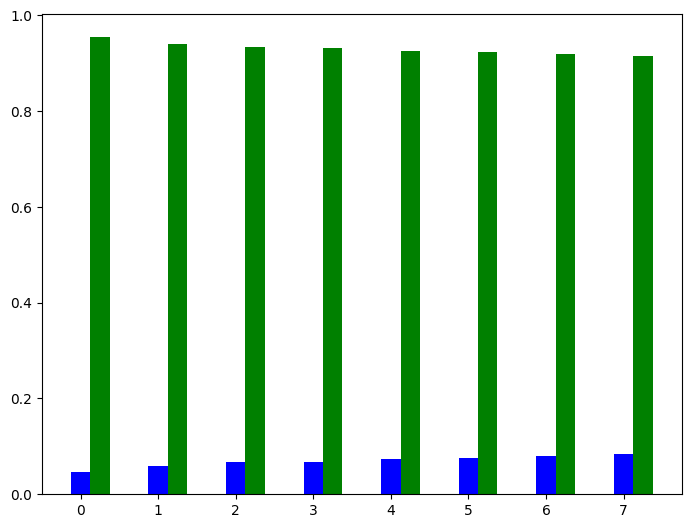

In [153]:
data = list(map(list, zip(*list(convert_woe_probs(relation_categorical_num_woe['AMT_INCOME_TOTAL']).values()))))
X = np.arange(len(data[0]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
plt.show()

In [143]:
def convert_woe_probs(dictionary):
    
    dic_copy = dictionary.copy()
    dic_copy = {k: v for k, v in sorted(dic_copy.items(), key=lambda item: item[1])}
    keys     = dic_copy.keys()
    
    for key in keys:
        
        woe = dic_copy[key]
        
        proportion = np.exp(woe)
        
        negatives  = 1/(1+proportion)
        positives  = 1-negatives
        
        dic_copy[key] = [positives, negatives]
        
        
    return dic_copy

In [120]:
list(convert_woe_probs(relation_categorical_num_woe['AMT_INCOME_TOTAL']).keys())

[0, 1, 2, 3, 4, 5, 7, 9]

In [123]:
columns = []
for x in list(convert_woe_probs(relation_categorical_num_woe['AMT_INCOME_TOTAL']).keys()):
    columns.append(str(x))

In [157]:
f    = open('Dics_bin_woe/dic_mon.txt','w')
f.write( str(relation_categorical_num_woe) )
f.close()

In [113]:
relation_categorical_num_woe

{'CNT_CHILDREN': {0: -2.485938654611713,
  1: -2.3223191045197993,
  2: -2.253741163938448,
  3: -1.951724118920733,
  4: -1.2992829841302609,
  5: -0.5108256237659907},
 'AMT_INCOME_TOTAL': {9: -2.3793865663306173,
  5: -2.499537092275369,
  7: -2.433367956626212,
  1: -2.759021746266542,
  3: -2.615041621143008,
  4: -2.526919424409836,
  0: -3.039668059258625,
  2: -2.639057329615259},
 'AMT_CREDIT_x': {9: -2.3257216196628065,
  7: -2.5007119744870145,
  5: -2.609500792069039,
  3: -2.7360148372201127,
  2: -3.007697441612264,
  1: -3.1024918101255246,
  6: -2.5599971011430704,
  0: -3.5536659753064286,
  4: -2.6516972645510783,
  8: -2.4485390056171257},
 'AMT_ANNUITY_x': {9.0: -2.3894986281127655,
  4.0: -2.6789613979399585,
  5.0: -2.589796466449139,
  7.0: -2.5420757803057787,
  0.0: -3.385577079043153,
  8.0: -2.4690503072898173,
  3.0: -2.7551760937626044,
  2.0: -3.0633909220278057,
  1.0: -3.0910424533583156,
  6.0: -2.5649493574615367},
 'AMT_GOODS_PRICE_x': {9.0: -2.260193

In [15]:
np.sum(pd.isnull(df_train['OBS_60_CNT_SOCIAL_CIRCLE']))

0

In [39]:
keys = list(relation_categorical_num_woe['OBS_60_CNT_SOCIAL_CIRCLE'].keys())
keys.remove('nan')
keys.sort()

In [22]:
float(keys[0])

0.0

In [34]:
keys[0]

0.0

In [38]:
keys

[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [41]:
relation_categorical_num_woe['OBS_60_CNT_SOCIAL_CIRCLE'][keys[0]]

-2.4598559001575477

In [9]:
def ordered_category(dict_category):
    
    keys = list(dict_category.keys())
    
    
    try: 
        keys.remove('nan')
    except ValueError:
        pass
    
    keys.sort()
    
    Violation = False
    index     = 1
    
    Ascending = True if dict_category[keys[0]] < dict_category[keys[1]] else False
    
    
    if Ascending: 
        
        while True:
            
            if dict_category[keys[index-1]] > dict_category[keys[index]]:
                
                Violation = True
            
            if index == len(keys)-1:
                break
            
            index += 1
            
    else:
        
        while True:
                
            if dict_category[keys[index-1]] < dict_category[keys[index]]:
                
                Violation = True
            
            if index == len(keys)-1:
                break
            
            index += 1
            
    return Violation

In [10]:
num_violations = 0

for category in load_vars('numerical'):
    
    violation = ordered_category(relation_categorical_num_woe[category])
    
    if violation:
        print(category)
        print(violation)
        print('='*50)
    
    num_violations += violation
    

print('Total violations: \t {}'.format(num_violations))

DAYS_FIRST_DUE
True
NUM_INSTALMENT_NUMBER
True
Total violations: 	 2


In [72]:
relation_categorical_num_woe['NUM_INSTALMENT_NUMBER']

{2.0: -2.4583936272847406,
 6.0: -2.393343226866504,
 7.0: -2.338774819011525,
 1.0: -2.4964260399352445,
 'nan': -2.754558239183039,
 0.0: -2.513458551716441,
 3.0: -2.444901315174301,
 5.0: -2.395536317507498,
 4.0: -2.1972245773362196}

# Calc Gini    

In [3]:
df_train  = pd.read_csv('Output_xgboost_binning/Training_with_woe_on_numerical.csv')
df_test   = pd.read_csv('Output_xgboost_binning/Testing_with_woe_on_numerical.csv')

In [4]:
def calc_gini(variable, target, variable_name, target_name):
    
    df_aux     = pd.DataFrame((variable,target)).transpose()
    
    categories = list(df_aux[variable_name].value_counts().index)
    
    positives  = df_aux.groupby(variable_name)[target_name].sum().values
    totals     = df_aux.groupby(variable_name)[target_name].count().values
    total      = len(variable)
    
    probs      = np.array(positives/totals)
        
    gini_nodes = probs * (1 - probs)
    gini       = np.sum(probs)
    
    return gini
    
def get_ginis(df, variables, target_name):
    
    ginis = {}
    
    for var in variables:
                
        gini      = calc_gini(df[var], df[target_name], var, target_name)

        ginis[var] = gini
    
    return ginis

In [5]:
variables = [*load_vars('numerical'), *load_vars('categorical')]

ginis_train = get_ginis(df_train, variables, 'TARGET')
ginis_test  = get_ginis(df_test , variables, 'TARGET')

In [6]:
variables = [*load_vars('numerical'), *load_vars('categorical')]


In [7]:
descriptor = pd.read_csv('Data/HomeCredit_columns_description.csv')

for var in variables:
    
    descriptor.loc[descriptor[descriptor['Row'] == var].index, 'Gini_train_monotonic'] = ginis_train[var]
    descriptor.loc[descriptor[descriptor['Row'] == var].index, 'Gini_test_monotonic']  = ginis_test[var]
    
descriptor.to_csv('Data/HomeCredit_columns_description.csv', index = False)
    